# **Machine Learning II: Deep learning classifiers for urban sound data**
<img src="https://github.com/alfredofdlv/MCII-Project/blob/main_alfredo/images/portrait.png?raw=1" alt="Portrait" style="width:100%; height:auto;">

===================================================================================================================


## **Introduction**
Urban sound recognition is a crucial component in the development of intelligent systems for cities, supporting applications in public safety, environmental monitoring, and transportation. This project focuses on designing and evaluating deep learning classifiers for recognizing urban sounds using the UrbanSound8K dataset. This dataset contains audio samples across 10 classes commonly found in urban environments, such as "siren," "dog bark," and "street music." To address the classification challenge, we implement two neural network architectures: a **Recurrent Neural Network (RNN)**, which leverages temporal patterns in audio data, and a **Multilayer Perceptron (MLP)**, which classifies extracted features based on dense, fully connected layers. By comparing these models, we aim to identify which architecture is more effective in urban sound classification tasks, balancing accuracy, computational efficiency, and model complexity.


### **Abstract**

This project presents a deep learning approach for urban sound classification, utilizing the UrbanSound8K dataset to train and evaluate two neural network models: a Recurrent Neural Network (RNN) and a Multilayer Perceptron (MLP). Our data preparation pipeline applies comprehensive preprocessing steps, including signal normalization and feature extraction, to transform raw audio signals into structured representations suitable for deep learning input. Model architectures are iteratively optimized through careful adjustment of layer configurations, activation functions, and hyperparameters to enhance performance.
Training strategies incorporate fine-tuning of optimizers, regularization techniques, and a robust 10-fold cross-validation approach to ensure reliable generalization and mitigate overfitting. Model performance is evaluated using classification accuracy and a cumulative confusion matrix across folds, providing insight into each model’s ability to handle distinct sound classes.

Training strategies included fine-tuning of optimizers and regularization techniques, alongside a robust **10-fold cross-validation** to assess generalization. Classification performance is evaluated based on accuracy and the confusion matrix across folds, providing insights into each model's strengths in handling distinct sound classes.

### **Objective of the work**
The primary objective of this project is to develop and assess the efficacy of two distinct neural network architectures—RNN and MLP—for urban sound classification. By conducting a comparative analysis, we aim to provide understanding of each model's performance, identifying the trade-offs in accuracy, computational demands, and architectural complexity.

### **Structure of the work**
The project is structured into the following sections:
1. **Data Preparation**: This section outlines the steps taken to preprocess the UrbanSound8K dataset
2. **Model Architectures**: A detailed description of the RNN and MLP models...
    - **RNN Architecture**: ...
    - **MLP Architecture**: ...
3. **Training Strategies**: This section discusses the training approaches used for both models...
4. **Evaluation Metrics**: A description of the metrics used to evaluate model performance...
5. **Results and Discussion**: A presentation of the results obtained from the models, including accuracy and ...

## **Data Preparation**

In [50]:
############## LIBRARIES ###############
import soundata
import librosa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from importlib import reload
import utils
import pickle
import random
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping


## Importing the data

Via the **soundata** library, we will be able to import the sound files as long as a .csv explanatory file, which will be really useful to determine the class of each audio.  

In [51]:
#Google Colab directory

!ls /content/
import sys
sys.path.append('/content/')



preprocessed_data.pkl  __pycache__  sample_data  UrbanSound8K.csv  utils.py


In [52]:
# directory=r'D:\data\ml2'
# dataset = soundata.initialize('urbansound8k', data_home=directory)
# dir_metadata=os.path.join(directory,"metadata","UrbanSound8k.csv")
# data=pd.read_csv(dir_metadata)
# data["fold"].value_counts()
# data["class"].value_counts()

## Feature Extraction

For our work with an Deep Learning models, it's essential to extract certain types of audio features, ensuring the model receives inputs it can effectively process. Using **librosa**,a library specifically designed to handle audio analysis, we can derive three main types of audio representations:

- **Waveform**: This a straightforward representation of sound,which captures the amplitude of an audio signal over time, offering a basic but crucial insight into the raw sound dynamics.



In [53]:
# dir_audio_example=os.path.join(directory,"audio","fold5","100032-3-0-0.wav")

# #Waveshow
# y,sr=librosa.load(dir_audio_example)
# librosa.display.waveshow(y, sr=sr)
# plt.title('Example of an original Waveshow')
# plt.show()

# #MFCC
# mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
# melspectrogram =librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
# mel_spectrogram_db = librosa.power_to_db(melspectrogram, ref=np.max)
# plt.figure(figsize=(14, 5))
# librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
# plt.colorbar(format='%+2.0f dB')
# plt.title('Example of a mel-scaled spectogram ')
# plt.show()

# #MFCC
# plt.figure(figsize=(10,4))
# librosa.display.specshow(mfccs, x_axis='time')
# plt.colorbar()
# plt.title('Example of an original MFCCs')
# plt.tight_layout()


## Feature Extraction

For our work with Deep Learning models, it's essential to extract certain types of audio features, ensuring the model receives inputs it can effectively process. Using **librosa**,a library specifically designed to handle audio analysis. We will extract the following characteristhics with the use of :

- **Zero Crossing Rate (ZCR)**: measures how often the audio signal crosses the zero axis over a set period. This metric is particularly useful for spotting sudden changes in the signal's spectral features. By capturing these shifts, it helps neural networks pick up on phase alterations within the audio, allowing for better sound pattern recognition.

- **Root Mean Square Energy (RMSE)**: is a measurement which returns the quadratic mean energy in each frame along the audio signal. Really useful to understand volumen levels and the intensity over time.  

- **Mel-Frequency Cepstral Coefficients (MFCCs)**: MFCCs are derived from the spectrogram but specifically designed to model human hearing. These coefficients compress the audio data while retaining its most perceptually relevant features.

- **Spectral Centroid**: is a measurement which represents, the weighted average of the frequencies of an spectrum of audio, as it indicates where does the majority of the spectral energy concentrate.

- **Spectral Bandwidth**:it measures the bandwidth of frequency along the average spectrum. It helps distinguising complex bandwidth, like noise, from more tonal sounds.

- **Spectral Rolloff**: marks the frequency below which a set portion of a signal’s total energy—usually 85% is found. It’s used in neural networks to help tell apart sharp, sudden sounds from steady, ongoing ones, making it easier to classify different audio events.

- **Spectrogram**: This visual format reveals how frequency components evolve over time, displaying changes in the sound's frequency structure.



In [54]:
# def extract_audio_features(filepath):
#     """
#     Extracts a comprehensive set of audio features from a given audio file.

#     Parameters:
#     filepath (str or Path): Path to the audio file.

#     Returns:
#     np.ndarray: Concatenated feature array for the given audio file.
#     """
#     y, sr = librosa.load(filepath, sr=None)

#     # Extracting audio features
#     zero_crossing_rate = librosa.feature.zero_crossing_rate(y=y).T
#     root_mean_square_energy = librosa.feature.rms(y=y).T
#     mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T
#     spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).T
#     spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).T
#     spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr,fmin=200.0, n_bands=6).T
#     spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).T
#     mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000).T

#     # Concatenating all features into a single array
#     features = np.concatenate(
#         (
#             mfccs, mel_spectrogram, zero_crossing_rate, root_mean_square_energy,
#             spectral_centroid, spectral_bandwidth, spectral_contrast, spectral_rolloff
#         ), axis=1
#     )

#     return features


# def generate_train_test_split(train_size=8):
#     """
#     Generates a train-test split of folds.

#     Parameters:
#     train_size (int): Number of folds to be used for training (default is 8).

#     Returns:
#     tuple: Lists containing the training and testing folds.
#     """
#     all_folds = list(range(1, 11))  # Folds numbered from 1 to 10
#     train_folds = random.sample(all_folds, train_size)
#     test_folds = [fold for fold in all_folds if fold not in train_folds]

#     return train_folds, test_folds


# def create_dataset(audio_directory, metadata_df, train_folds, test_folds):
#     """
#     Creates the dataset for training and testing neural network models.

#     Parameters:
#     audio_directory (str or Path): Directory containing the audio files.
#     metadata_df (DataFrame): DataFrame containing metadata for the audio files (must include 'slice_file_name', 'fold', 'classID').
#     train_folds (list): List of fold numbers to be used for training.
#     test_folds (list): List of fold numbers to be used for testing.

#     Returns:
#     tuple: Scaled feature arrays and corresponding labels for training and testing datasets.
#     """
#     audio_directory = Path(audio_directory)
#     train_features, test_features = [], []
#     y_train, y_test = [], []

#     # Extract features for each audio file
#     for file in audio_directory.rglob("*.wav"):
#         fold = metadata_df.loc[metadata_df['slice_file_name'] == file.name, 'fold'].iloc[0]
#         features = extract_audio_features(file)

#         if fold in train_folds:
#             y_train.append(metadata_df.loc[metadata_df['slice_file_name'] == file.name, 'class'].iloc[0])
#             train_features.append(features)
#         else:
#             y_test.append(metadata_df.loc[metadata_df['slice_file_name'] == file.name, 'class'].iloc[0])
#             test_features.append(features)

#     # Scaling features
#     train_features_combined = np.vstack(train_features)
#     scaler = StandardScaler()
#     scaler.fit(train_features_combined)

#     X_train = [scaler.transform(features) for features in train_features]
#     X_test = [scaler.transform(features) for features in test_features]

#     return X_train, X_test, y_train, y_test


After the feature extraction, we sample randomly which folds will be for train and test. And finally we will create the dataset, splitted by train, test and features and labels. We will save the dataset in a pickle file facilitating importing the data.

In [55]:
# reload(utils)
# from utils import generate_train_set,create_dataset
# print(data.columns)
# train, test=generate_train_set(8)
# dir_audio=os.path.join(directory,"audio")
# X_train,X_test,y_train,y_test=create_dataset(dir_audio,data,train,test)

# # Guardar todas las características y etiquetas en un archivoc
# with open("preprocessed_data.pkl", "wb") as f:
#     pickle.dump({
#         "X_train": X_train,
#         "X_test": X_test,
#         "y_train": y_train,
#         "y_test": y_test
#     }, f)

In [56]:
# Cargar los datos preprocesados desde el archivo
with open("/content/preprocessed_data.pkl", "rb") as f:
    new_data = pickle.load(f)

X_train = new_data["X_train"]
X_test = new_data["X_test"]
y_train = new_data["y_train"]
y_test = new_data["y_test"]

# Recurrent Neural Networks

**Recurrent Neural Networks (RNNs)** is a type of neural network architecture designed to model sequential data, with the use of feedback loops it allows information to persist across time steps, helping retaining information about past dependencies. In traditional neural networks, th input and output layers were connected in a feed-forward manner, meaning information flew one way, from input to output, with no feedback.

In RNNs this is not the case, as it incorporates **cyclic connections** that enables continuous information flow throughout each step of the sequence. This structure allows the RNNs to capture and model temporal and contextual relationships over time effectively.



155.41842445114077


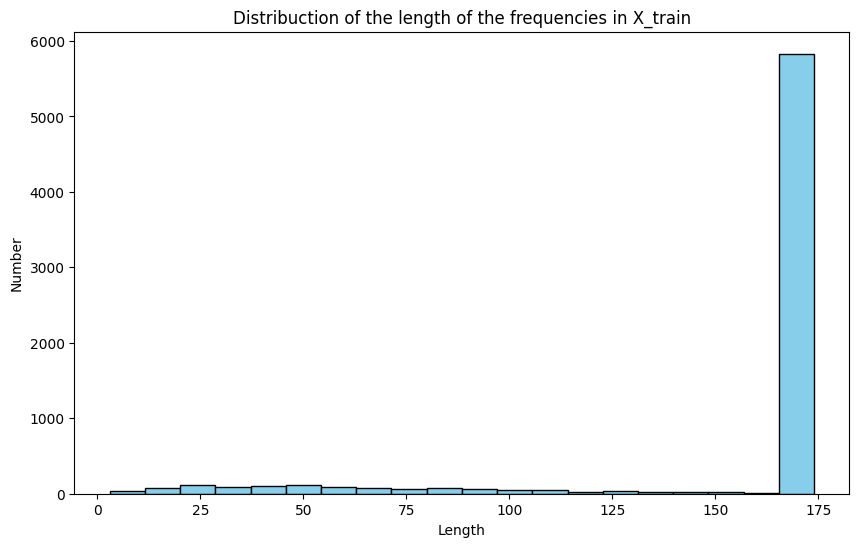

In [57]:
sequence_lengths = [len(seq) for seq in X_train]
print(np.mean(sequence_lengths))
# Graficar la distribución de longitudes de las secuencias
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribuction of the length of the frequencies in X_train')
plt.xlabel('Length')
plt.ylabel('Number')
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Clases: ['air_conditioner' 'car_horn' 'children_playing' 'dog_bark' 'drilling'
 'engine_idling' 'gun_shot' 'jackhammer' 'siren' 'street_music']


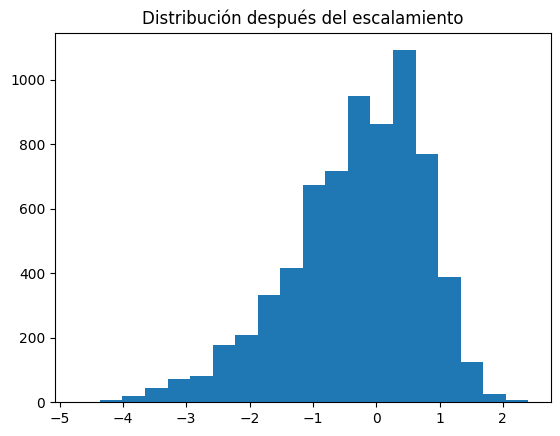

Forma de X_train después de padding: (6969, 174, 153)
Forma de X_test después de padding: (1763, 174, 153)


In [58]:


# Crear el codificador de etiquetas
label_encoder = LabelEncoder()

# Ajustar y transformar las etiquetas de entrenamiento
y_train_numeric = label_encoder.fit_transform(y_train)

# Transformar las etiquetas de prueba usando el mismo codificador
y_test_numeric = label_encoder.transform(y_test)

# Imprimir las clases asignadas
print("Clases:", label_encoder.classes_)

# Definir la longitud máxima deseada (por ejemplo, el máximo de tus secuencias o una longitud específica)
max_timesteps = max(sequence_lengths)  # Ajusta este valor según la longitud máxima de tus secuencias

# Aplicar padding
X_train_padded = pad_sequences(X_train, maxlen=max_timesteps, padding='post', dtype='float32')
X_test_padded = pad_sequences(X_test, maxlen=max_timesteps, padding='post', dtype='float32')

print(X_train_padded.shape)
plt.hist(X_train_padded[:, 0, 4], bins=20)  # Selecciona una característica para visualizar
plt.title('Distribución después del escalamiento')
plt.show()

# Verificar las dimensiones de los datos después del padding
print("Forma de X_train después de padding:", X_train_padded.shape)
print("Forma de X_test después de padding:", X_test_padded.shape)

num_classes = len(np.unique(y_train))

# Convertir etiquetas de y_train y y_test a one-hot encoding
y_train = to_categorical(y_train_numeric, num_classes=num_classes)
y_test = to_categorical(y_test_numeric, num_classes=num_classes)


In [74]:

from tensorflow.keras.layers import  BatchNormalization



model = Sequential()
# Primera capa LSTM: devuelve toda la secuencia
model.add(LSTM(128, input_shape=(X_train_padded.shape[1], X_train_padded.shape[2]), activation='relu', return_sequences=True))

# Segunda capa LSTM: devuelve solo la salida final
model.add(LSTM(64, activation='relu', return_sequences=False))

# Capa densa con Dropout para evitar sobreajuste
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))

# Capa de salida
model.add(Dense(10, activation='softmax'))



optimizer = tf.keras.optimizers.Adam(clipvalue=1.0,learning_rate=0.0001) # Clip gradients to a maximum value of 1.0


# Compilar el modelo
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


# Imprimir un resumen del modelo
model.summary()




/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 174, 128)            │         144,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 198,602 (775.79 KB)

 Trainable params: 198,602 (775.79 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
# Entrenar el modelo
history = model.fit(X_train_padded, y_train, epochs=20, batch_size=32, validation_split=0.2,callbacks=[early_stopping])


Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 78s 427ms/step - accuracy: 0.0919 - loss: 1523886.1250 - val_accuracy: 0.1241 - val_loss: 4412.3887
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 431ms/step - accuracy: 0.1052 - loss: 2717622.0000 - val_accuracy: 0.1176 - val_loss: 13473366.0000
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 80s 421ms/step - accuracy: 0.1100 - loss: 25343278.0000 - val_accuracy: 0.1492 - val_loss: 8813439.0000
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 74s 422ms/step - accuracy: 0.1398 - loss: 79675360.0000 - val_accuracy: 0.1686 - val_loss: 14715568.0000
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 429ms/step - accuracy: 0.1496 - loss: 129995864.0000 - val_accuracy: 0.1829 - val_loss: 69663600.0000
Epoch 6/20


KeyboardInterrupt: 

In [68]:
# Evaluar el modelo en los datos de prueba
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("Pérdida en test:", test_loss)
print("Precisión en test:", test_accuracy)


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.1421 - loss: 2.2648
Pérdida en test: 2.263596296310425
Precisión en test: 0.12081678956747055


In [69]:
# Hacer predicciones
predictions = model.predict(X_test_padded)

# Convertir probabilidades a etiquetas de clase
predicted_classes = np.argmax(predictions, axis=1)


56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step


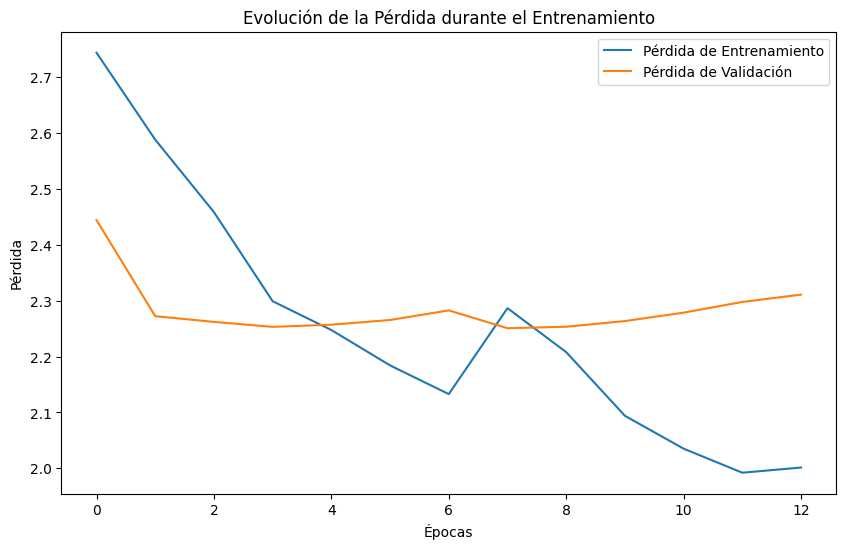

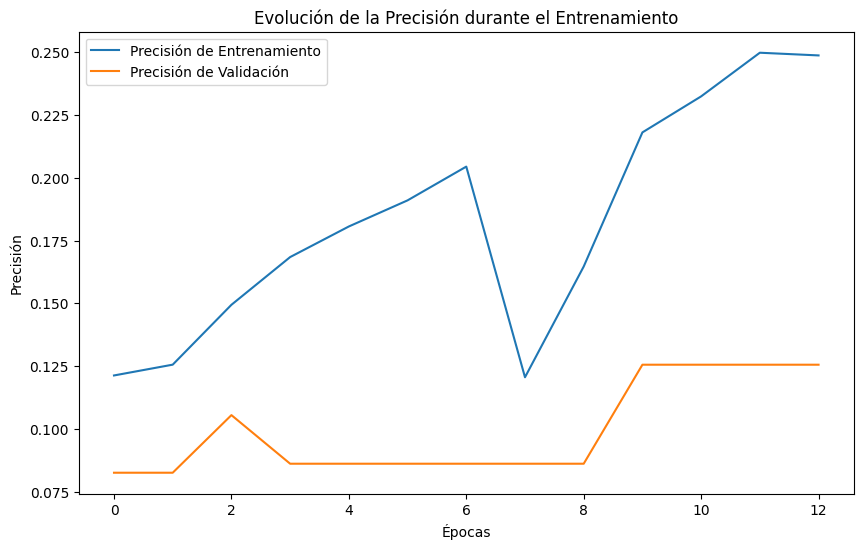

In [70]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Verifica primero si existen las claves 'loss' y 'val_loss' en el historial
if 'loss' in history.history and 'val_loss' in history.history:
    # Graficar la pérdida de entrenamiento y de validación
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida de Validación')
    plt.title('Evolución de la Pérdida durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()
else:
    print("No se encontraron las claves 'loss' o 'val_loss' en history.history")

# Graficar la precisión si también está disponible
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
    plt.title('Evolución de la Precisión durante el Entrenamiento')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()
    plt.show()
else:
    print("No se encontraron las claves 'accuracy' o 'val_accuracy' en history.history")

